<h1>Experiments with Gaussian + Linear fits to spectra</h1>

Fitters tested in this notebook:

- astropy.modeling.fitting
  - Levenberg-Marquardt
  - Simplex
  - SLSQP
- scipy.optimize.curve_fit
- lmfit
- saba (Sherpa)
  - Levenberg-Marquardt
  - Moncar
  - Nelder-Mead
  
Note that Saba requires that this notebook must be run under python 2.7  

In [1]:
from __future__ import print_function

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\mu$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [0.8, 2.4, 2.8e-15, 4.e-15]

<h3>Get raw data</h3>

This is the same dataset shown in github issue #145. 

In [2]:
data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]

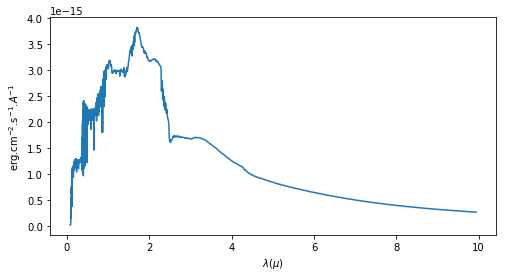

In [3]:
plt.gcf().set_size_inches(8.,4.)
plt.plot(wave, flux)
plt.xlabel(x_label)
plt.ylabel(y_label)

<h3>Extract regions of interest </h3>

Here we extract two ROIs: 
 - the exact same ROI displayed in issue #145 (1.09$\mu$ < wavelength < 2.25$\mu$)
 - a slightly wider ROI (0.9$\mu$ < wavelength < 2.35$\mu$) that includes some contamination at the edges to test the fitter's sensitivity to ROI selection.

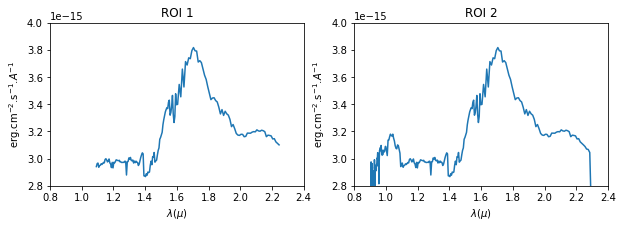

In [4]:
indices = (wave > 1.09) & (wave < 2.25) 
w1 = wave[indices]
f1 = flux[indices]
indices = (wave > 0.9) & (wave < 2.35) 
w2 = wave[indices]
f2 = flux[indices]

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("ROI 2")

<h3>Build compound models</h3>

For each ROI, we build two Gaussian+linear models. Each one is initialized in a different way:
 - we separately and independently initialize the Gaussian and linear components based on the data. This is what specviz does.
 - we simultaneously compute all the 5 initialization parameters (3 for the Gaussian, 2 for the linear) based on the data.
 
A third model applicaple on any ROI uses whatever default initialization is provided by the tested library (thus disregarding the data).

In [5]:
from astropy.modeling import models

def initialize_gaussian(w, f):
    centroid = np.sum(w * f) / np.sum(f)

    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
    sigma = fwhm / 2.355

    delta_w = w[1:] - w[:-1]
    sum_f = np.sum((f[1:] - np.min(f[1:])) * delta_w)
    height = sum_f / (sigma * np.sqrt( 2 * np.pi))
    
    return height, centroid, sigma

def initialize_linear(w, f):
    # compute averages at the 5% of data at each extreme of the wavelength range.
    l = int(len(w) / 20)
    w1 = np.mean(w[0:l])
    w2 = np.mean(w[-l-1:-1])
    f1 = np.mean(f[0:l])
    f2 = np.mean(f[-l-1:-1])
    # fit a straigth line thru these 
    slope = (f2 - f1) / (w2 - w1)
    inter = f2 - slope * w2
    return slope, inter

def initialize_compound(w, f):
    slope, inter = initialize_linear(w, f)
    fc = f - (w * slope + inter)
    height, centroid, sigma = initialize_gaussian(w, fc)
    return height, centroid, sigma, slope, inter
    
# independent Gaussian and linear initializations - ROIs 1 and 2
h, c, s = initialize_gaussian(w1, f1)
gaussian_s_1 = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
s, i = initialize_linear(w1, f1)
linear_s_1 = models.Linear1D(slope=s, intercept=i)
model_s_1 = gaussian_s_1 + linear_s_1

h, c, s = initialize_gaussian(w2, f2)
gaussian_s_2 = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
s, i = initialize_linear(w2, f2)
linear_s_2 = models.Linear1D(slope=s, intercept=i)
model_s_2 = gaussian_s_2 + linear_s_2

# Gaussian + linear initialized all at once - ROIs 1 and 2
height, centroid, sigma, slope, inter = initialize_compound(w1, f1)
gaussian_c_1 = models.Gaussian1D(amplitude=height, mean=centroid, stddev=sigma)
linear_c_1 = models.Linear1D(slope=slope, intercept=inter)
model_c_1 = gaussian_c_1 + linear_c_1
p1 = [height, centroid, sigma, slope, inter]

height, centroid, sigma, slope, inter = initialize_compound(w2, f2)
gaussian_c_2 = models.Gaussian1D(amplitude=height, mean=centroid, stddev=sigma)
linear_c_2 = models.Linear1D(slope=slope, intercept=inter)
model_c_2 = gaussian_c_2 + linear_c_2
p2 = [height, centroid, sigma, slope, inter]

# Default initialization
model_d = models.Gaussian1D() + models.Linear1D()

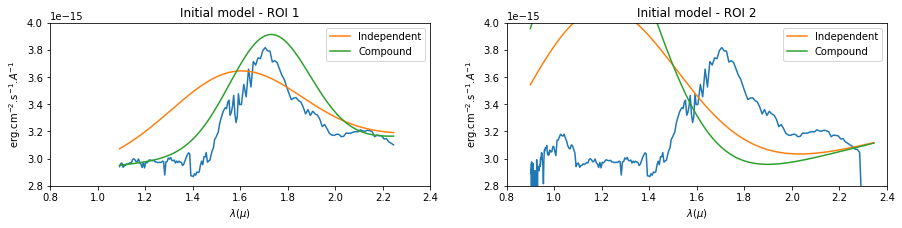

In [6]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, model_s_1(w1), label='Independent')
plt.plot(w1, model_c_1(w1), label='Compound')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Initial model - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, model_s_2(w2), label='Independent')
plt.plot(w2, model_c_2(w2), label='Compound')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Initial model - ROI 2")

The default iitialization is not plotted because it is way off scale.

<h3>Fit using astropy</h3>

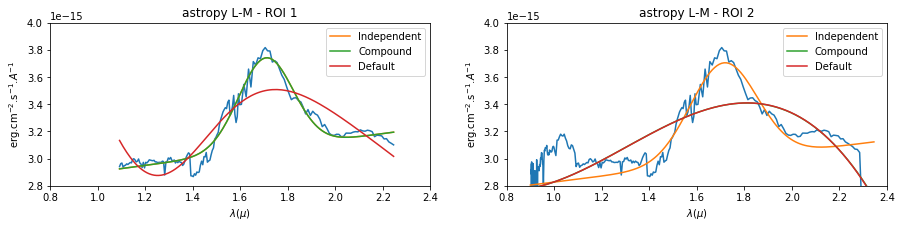

In [7]:
from astropy.modeling import fitting

# L-M

lm_fitter = fitting.LevMarLSQFitter()
maxi = 2000

lm_fm_s_1 = lm_fitter(model_s_1, w1, f1, maxiter=maxi)
lm_fm_s_2 = lm_fitter(model_s_2, w2, f2, maxiter=maxi)
lm_fm_c_1 = lm_fitter(model_c_1, w1, f1, maxiter=maxi)
lm_fm_c_2 = lm_fitter(model_c_2, w2, f2, maxiter=maxi)
lm_fm_d_1 = lm_fitter(model_d, w1, f1, maxiter=maxi)
lm_fm_d_2 = lm_fitter(model_d, w2, f2, maxiter=maxi)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, lm_fm_s_1(w1), label='Independent')
plt.plot(w1, lm_fm_c_1(w1), label='Compound')
plt.plot(w1, lm_fm_d_1(w1), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy L-M - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, lm_fm_s_2(w2), label='Independent')
plt.plot(w2, lm_fm_c_2(w2), label='Compound')
plt.plot(w2, lm_fm_d_2(w2), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy L-M - ROI 2")

In [8]:
print(lm_fitter.fit_info['message'])

Number of calls to function has reached maxfev = 2000.


The compound and independent initializations above, in each ROI, give identical results. The default initialization runs out of iterations. I tried up to 20,000 iterations and got the same solutions and same warning every time.

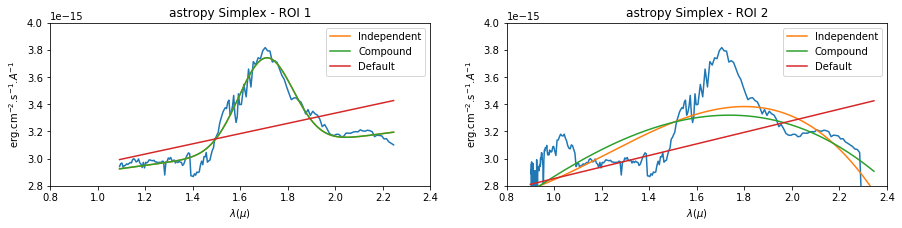

In [9]:
# Simplex

simplex_fitter = fitting.SimplexLSQFitter()
maxi = 2000

simplex_fm_s_1 = simplex_fitter(model_s_1, w1, f1, maxiter=maxi)
simplex_fm_s_2 = simplex_fitter(model_s_2, w2, f2, maxiter=maxi)
simplex_fm_c_1 = simplex_fitter(model_c_1, w1, f1, maxiter=maxi)
simplex_fm_c_2 = simplex_fitter(model_c_2, w2, f2, maxiter=maxi)
simplex_fm_d_1 = simplex_fitter(model_d, w1, f1, maxiter=maxi)
simplex_fm_d_2 = simplex_fitter(model_d, w2, f2, maxiter=maxi)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, simplex_fm_s_1(w1), label='Independent')
plt.plot(w1, simplex_fm_c_1(w1), label='Compound')
plt.plot(w1, simplex_fm_d_1(w1), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy Simplex - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, simplex_fm_s_2(w2), label='Independent')
plt.plot(w2, simplex_fm_c_2(w2), label='Compound')
plt.plot(w2, simplex_fm_d_2(w2), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy Simplex - ROI 2")

As in the L-M case, the compound and independent initializations gave identical results in ROI 1. 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.52520660177477e-29
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.368959989593038e-28
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.046578224205755e-30
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.149381660920577e-28
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.44838126632914e-08
            Iterations: 25
            Functi

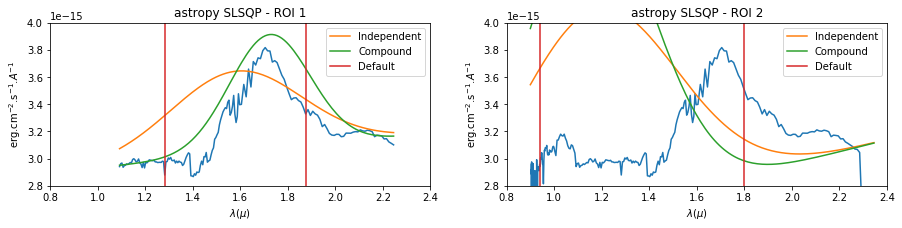

In [10]:
# SLSQP

slsqp_fitter = fitting.SLSQPLSQFitter()
maxi = 2000

slsqp_fm_s_1 = slsqp_fitter(model_s_1, w1, f1, maxiter=maxi)
slsqp_fm_s_2 = slsqp_fitter(model_s_2, w2, f2, maxiter=maxi)
slsqp_fm_c_1 = slsqp_fitter(model_c_1, w1, f1, maxiter=maxi)
slsqp_fm_c_2 = slsqp_fitter(model_c_2, w2, f2, maxiter=maxi)
slsqp_fm_d_1 = slsqp_fitter(model_d, w1, f1, maxiter=maxi)
slsqp_fm_d_2 = slsqp_fitter(model_d, w2, f2, maxiter=maxi)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, slsqp_fm_s_1(w1), label='Independent')
plt.plot(w1, slsqp_fm_c_1(w1), label='Compound')
plt.plot(w1, slsqp_fm_d_1(w1), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy SLSQP - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, slsqp_fm_s_2(w2), label='Independent')
plt.plot(w2, slsqp_fm_c_2(w2), label='Compound')
plt.plot(w2, slsqp_fm_d_2(w2), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy SLSQP - ROI 2")

It looks like the SLSQP fitter didn't do anything, because the solutions look identical to the initial models. 

<h3>Repeat with optimize.curve_fit fitter </h3>

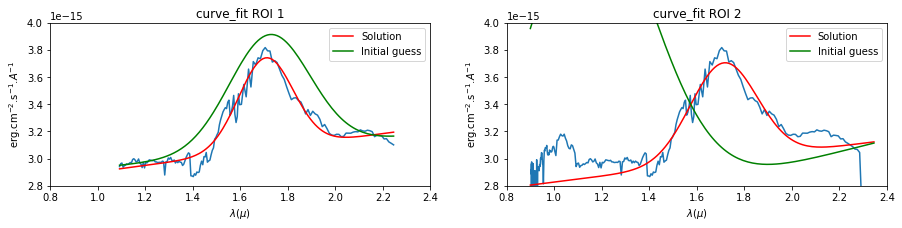

In [11]:
from scipy.optimize import curve_fit

def func(x, a, x0, sigma, slope, intercept):
    return (models.Gaussian1D(amplitude=a, mean=x0, stddev=sigma) + \
            models.Linear1D(slope=slope, intercept=intercept))(x)

# Calling 'curve_fit' with initial guesses for the parameters does not work 
# regardless of the combination of first guesses and  methods used.
# 
# These calls either raise an exception when reaching maxfev, or just skip
# everything and return the first guesses as the answer. 
#
# Note that method 'lm' basically calls the same 'leastsq' function used by 
# astropy's L-M fitter. It can't deal with bounds though; for that, method 
# 'trf' would be required.

# popt1, pcov1 = curve_fit(func, w1, f1, p0=p1, method='lm', maxfev=10000)
# popt2, pcov2 = curve_fit(func, w2, f2, p0=p2, method='lm', maxfev=10000)

# Not providing first guesses or method: this will runs the 'lm' method and
# uses default first guesses. Surprisingly (for ROI 2), it seems to work.
popt1, pcov1 = curve_fit(func, w1, f1)
popt2, pcov2 = curve_fit(func, w2, f2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, func(w1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), color='red', label='Solution')
plt.plot(w1, func(w1, p1[0], p1[1], p1[2], p1[3], p1[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("curve_fit ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, func(w2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), color='red', label='Solution')
plt.plot(w2, func(w2, p2[0], p2[1], p2[2], p2[3], p2[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("curve_fit ROI 2")

Note that curve_fit does not require any initialization.

<h3>Repeat with Model from lmfit </h3>

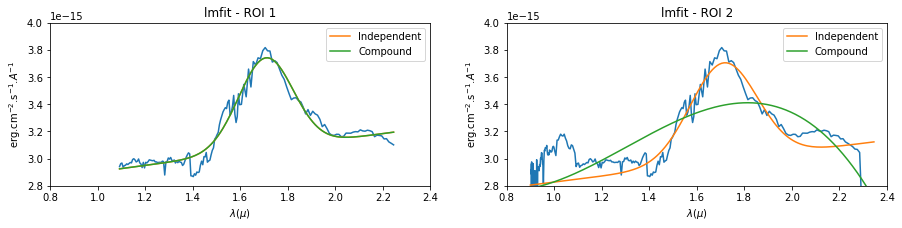

In [12]:
from lmfit import Model

def gaussian(x, amp, cen, wid):
    return models.Gaussian1D(amplitude=amp, mean=cen, stddev=wid)(x)

def linear(x, slope, inter):
    return models.Linear1D(slope=slope, intercept=inter)(x)

# lmfit doesn't support parameter default values. Initialize with specviz values.

# independent Gaussian and linear initializations - ROIs 1 and 2
mod_s_1 = Model(gaussian) + Model(linear)
h, c, sigma = initialize_gaussian(w1, f1)
slope, i = initialize_linear(w1, f1)
pars_s_1 = mod_s_1.make_params(amp=h, cen=c, wid=sigma, slope=slope, inter=i)
lmfit_fm_s_1 = mod_s_1.fit(f1, pars_s_1, x=w1)

mod_s_2 = Model(gaussian) + Model(linear)
h, c, sigma = initialize_gaussian(w2, f2)
slope, i = initialize_linear(w2, f2)
pars_s_2 = mod_s_2.make_params(amp=h, cen=c, wid=sigma, slope=slope, inter=i)
lmfit_fm_s_2 = mod_s_2.fit(f2, pars_s_2, x=w2)

# Gaussian + linear initialized all at once - ROIs 1 and 2
mod_c_1 = Model(gaussian) + Model(linear)
h, c, sigma, slope, i = initialize_compound(w1, f1)
pars_c_1 = mod_c_1.make_params(amp=h, cen=c, wid=sigma, slope=slope, inter=i)
lmfit_fm_c_1 = mod_c_1.fit(f1, pars_c_1, x=w1)

mod_c_2 = Model(gaussian) + Model(linear)
h, c, sigma, slope, i = initialize_compound(w2, f2)
pars_c_2 = mod_c_2.make_params(amp=h, cen=c, wid=sigma, slope=slope, inter=i)
lmfit_fm_c_2 = mod_c_2.fit(f2, pars_c_2, x=w2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, lmfit_fm_s_1.best_fit, label='Independent')
plt.plot(w1, lmfit_fm_c_1.best_fit, label='Compound')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("lmfit - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, lmfit_fm_s_2.best_fit, label='Independent')
plt.plot(w2, lmfit_fm_c_2.best_fit, label='Compound')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("lmfit - ROI 2")

<h3>Repeat with Sherpa </h3>

In [13]:
from astropy.modeling.fitting import SherpaFitter

# L-M

saba_lm_fitter = SherpaFitter(statistic='leastsq', optimizer='levmar', estmethod='confidence')

saba_lm_fm_s_1 = saba_lm_fitter(model_s_1, w1, f1)
saba_lm_fm_s_2 = saba_lm_fitter(model_s_2, w2, f2)
saba_lm_fm_c_1 = saba_lm_fitter(model_c_1, w1, f1)
saba_lm_fm_c_2 = saba_lm_fitter(model_c_2, w2, f2)
saba_lm_fm_d_1 = saba_lm_fitter(model_d, w1, f1)
saba_lm_fm_d_2 = saba_lm_fitter(model_d, w2, f2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, saba_lm_fm_s_1(w1), label='Independent')
plt.plot(w1, saba_lm_fm_c_1(w1), label='Compound')
plt.plot(w1, saba_lm_fm_d_1(w1), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Sherpa L-M - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, saba_lm_fm_s_2(w2), label='Independent')
plt.plot(w2, saba_lm_fm_c_2(w2), label='Compound')
plt.plot(w2, saba_lm_fm_d_2(w2), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Sherpa L-M - ROI 2")

ImportError: cannot import name 'SherpaFitter'

In [ ]:
# Moncar (Differential Evolution algorithm based on Storn and Price,J.,Global Optimization 11, 341-359, 1997)

saba_moncar_fitter = SherpaFitter(statistic='leastsq', optimizer='moncar', estmethod='confidence')

saba_moncar_fm_s_1 = saba_moncar_fitter(model_s_1, w1, f1)
saba_moncar_fm_s_2 = saba_moncar_fitter(model_s_2, w2, f2)
saba_moncar_fm_c_1 = saba_moncar_fitter(model_c_1, w1, f1)
saba_moncar_fm_c_2 = saba_moncar_fitter(model_c_2, w2, f2)
saba_moncar_fm_d_1 = saba_moncar_fitter(model_d, w1, f1)
saba_moncar_fm_d_2 = saba_moncar_fitter(model_d, w2, f2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, saba_moncar_fm_s_1(w1), label='Independent')
plt.plot(w1, saba_moncar_fm_c_1(w1), label='Compound')
plt.plot(w1, saba_moncar_fm_d_1(w1), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Sherpa Moncar - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, saba_moncar_fm_s_2(w2), label='Independent')
plt.plot(w2, saba_moncar_fm_c_2(w2), label='Compound')
plt.plot(w2, saba_moncar_fm_d_2(w2), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Sherpa Moncar - ROI 2")

In [ ]:
# Nelder-Mead 

saba_nm_fitter = SherpaFitter(statistic='leastsq', optimizer='neldermead', estmethod='confidence')

saba_nm_fm_s_1 = saba_nm_fitter(model_s_1, w1, f1)
saba_nm_fm_s_2 = saba_nm_fitter(model_s_2, w2, f2)
saba_nm_fm_c_1 = saba_nm_fitter(model_c_1, w1, f1)
saba_nm_fm_c_2 = saba_nm_fitter(model_c_2, w2, f2)
saba_nm_fm_d_1 = saba_nm_fitter(model_d, w1, f1)
saba_nm_fm_d_2 = saba_nm_fitter(model_d, w2, f2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, saba_nm_fm_s_1(w1), label='Independent')
plt.plot(w1, saba_nm_fm_c_1(w1), label='Compound')
plt.plot(w1, saba_nm_fm_d_1(w1), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Sherpa Nelder-Mead - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, saba_nm_fm_s_2(w2), label='Independent')
plt.plot(w2, saba_nm_fm_c_2(w2), label='Compound')
plt.plot(w2, saba_nm_fm_d_2(w2), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Sherpa Nelder-Mead - ROI 2")

#### Sherpa Simplex - it runs (CPU is busy) but doesn't report anything. Fitter object becomes unresponsive afterwards.

# Summary


|Fitter            | Initialization |    ROI 1             |     ROI 2           |
|------------------|----------------|----------------------|---------------------|
| astropy L-M      | independent    | FIT WORKS            | FIT WORKS           |
| astropy L-M      | compound       | FIT WORKS            | FIT WORKS           |
| astropy L-M      | default        | moves closer         | moves closer        |
|                  |                |                      |                     |
| astropy Simplex  | independent    | FIT WORKS            | moves closer        |
| astropy Simplex  | compound       | FIT WORKS            | moves closer        |
| astropy Simplex  | default        | Gaussian disappears  | Gaussian disappears |
|                  |                |                      |                     |
| astropy SLSQP    | independent    | does nothing         | does nothing        |
| astropy SLSQP    | compound       | does nothing         | does nothing        |
| astropy SLSQP    | default        | diverges             | diverges            |
|                  |                |                      |                     |
| scipy curve_fit  | default        | FIT WORKS            | FIT WORKS           |
|                  |                |                      |                     |
| lmfit            | independent    | FIT WORKS            | FIT WORKS           |
| lmfit            | compound       | FIT WORKS            | doesn't work        |
|                  |                |                      |                     |
| Sherpa L-M       | independent    | FIT WORKS            | FIT WORKS           |
| Sherpa L-M       | compound       | FIT WORKS            | FIT WORKS           |
| Sherpa L-M       | default        | moves closer         | moves closer        |
|                  |                |                      |                     |
| Sherpa Moncar    | independent    | FIT WORKS            | moves closer        |
| Sherpa Moncar    | compound       | FIT WORKS            | moves closer        |
| Sherpa Moncar    | default        | Gaussian disappears  | Gaussian disappears |
|                  |                |                      |                     |
| Sherpa N-M       | independent    | moves closer         | FIT WORKS           |
| Sherpa N-M       | compound       | moves closer         | FIT WORKS           |
| Sherpa N-M       | default        | diverges             | diverges            |

# Maybe worthwhile to look into

- https://github.com/tiagopereira/python_tips/wiki/Scipy:-curve-fitting
- http://central.scipy.org/item/28/2/fitting-a-gaussian-to-noisy-data-points 

  - Looked into this. I don't quite get the author's point. From the code viewpoint, it looks like the algorithm has to do with fitting a Gaussian by fitting an (approximatley) equivalent parabola to the log of the data. This won't solve our problem with negative sigmas and z's (see experiment_redshift.ipynb notebook). In any case, the code (specifically, the fit_direct function) can't be used in the context of compound models since the model in this case is implicit and set to be one single, isolated Gaussian. The code is just a call to np.linalg.lstsq, I don't see how it's going to help us in any way different than astropy already does. 

- http://www.adamgginsburg.com/pygaussfit.htm

# Tests with the absorption Gaussian model

The GaussianAbsorption1D model in astropy is defined as (1. - Gaussian1D). This won't work when the independent variable is expressed in units such as $f_{\lambda}$, since the numerical values are very small (~ 1.E-15). Subtracting these values from 1. results in essentially an array of ones. 

The test below shows what happens when we use instead of GaussianAbsorption1D, just Gaussian1D with a negative amplitude, and keep the initialization code the same. 

In [ ]:
indices = (wave > 0.475) & (wave < 0.497) 
w1 = wave[indices]
f1 = flux[indices]

# independent Gaussian and linear initializations
h, c, s = initialize_gaussian(w1, f1)
# gaussian_s_1 = models.GaussianAbsorption1D(amplitude=h, mean=c, stddev=s)
gaussian_s_1 = models.Gaussian1D(amplitude=-h, mean=c, stddev=s)
s, i = initialize_linear(w1, f1)
linear_s_1 = models.Linear1D(slope=s, intercept=i)
model_s_1 = gaussian_s_1 + linear_s_1

# Gaussian + linear initialized all at once 
height, centroid, sigma, slope, inter = initialize_compound(w1, f1)
# gaussian_c_1 = models.GaussianAbsorption1D(amplitude=height, mean=centroid, stddev=sigma)
gaussian_c_1 = models.Gaussian1D(amplitude=-height, mean=centroid, stddev=sigma)
linear_c_1 = models.Linear1D(slope=slope, intercept=inter)
model_c_1 = gaussian_c_1 + linear_c_1

plot_axis = [0.47, 0.5, 1.e-15, 2.5e-15]
plt.gcf().set_size_inches(8.,4.)
plt.plot(w1, f1, label='Data')
plt.plot(w1, model_s_1(w1), label='Independent initialization')
plt.plot(w1, model_c_1(w1), label='Compound initialization')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Initial model")

The proposal for specviz is to replace the astropy version of absorption Gaussian with our own version, in which we will call the Gaussian1D model with negative amplitude. Thus it will share the common initialization code with the other emission line types. 

Or we could write our own absorption Gaussian, parametrized by optical depth or equivalent width.

In [ ]:
# Fit absorption Gaussian as defined above

lm_fitter = fitting.LevMarLSQFitter()
lm_fm_s_1 = lm_fitter(model_s_1, w1, f1, maxiter=2000)
lm_fm_c_1 = lm_fitter(model_c_1, w1, f1, maxiter=2000)

plt.gcf().set_size_inches(8.,4.)
plt.plot(w1, f1, label='Data')
plt.plot(w1, lm_fm_s_1(w1), label='Independent')
plt.plot(w1, lm_fm_c_1(w1), label='Compound')
plt.axis(plot_axis)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("L-M fit to absorption Gaussian")

Even though this worked well, I found that the independent initialization doesn't work so well under specviz, even with similar data.

Lets try to work out a better initialization for the absorption Gaussian, in the lines of having a sort of linear+gaussian compound under the hood.


In [ ]:
def initialize_gaussian_absorption(w, f):
    
    # start by computing an approximate linear continuum
    s, i = initialize_linear(w, f)

    # centroid is computed by subtracting this continuum 
    # estimate and then using it in the same way that is
    # used for computing the centroid of the emission Gaussian. 
    c = models.Linear1D(slope=slope, intercept=i)(w)
    f_s = f - c
    centroid = np.sum(w * f_s) / np.sum(f_s)

    # sigma is computed in the same way as with the emission 
    # Gaussian, but again using the continuum-subtracted data. 
    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f_s) / np.sum(f_s))
    sigma = fwhm / 2.355

    # amplitude is estimated from the difference in areas under the
    # (interpolated) linear continumm and the actual data.
    delta_w = w[1:] - w[:-1]
    sum_c = np.sum(c[1:] * delta_w)
    sum_f = np.sum(f[1:] * delta_w)
    amplitude = (sum_f - sum_c) / (sigma * np.sqrt( 2 * np.pi))
    
    return amplitude, centroid, sigma

# note that the amplitude parameter 'h' is already negative
h, c, s = initialize_gaussian_absorption(w1, f1)
gaussian_s_1 = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
s, i = initialize_linear(w1, f1)
linear_s_1 = models.Linear1D(slope=s, intercept=i)
model_s_1 = gaussian_s_1 + linear_s_1

plot_axis = [0.47, 0.5, 1.e-15, 2.5e-15]
plt.gcf().set_size_inches(8.,4.)
plt.plot(w1, f1, label='Data')
plt.plot(w1, model_s_1(w1), label='Model')
plt.axis(plot_axis)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Proposed new initailzation method")

An absorption line only makes sense if there is a pre-existing continuum, so no wonder we get a much better initial guess when we explictly take into account the continuum, even in an approximate form.